## Iquitos, Peru
This notebook contains some EDA (deeper than the eda.ipynb, and specific only to Iquitos), and also some feature processing for Iquitos.

There are also some preliminary baseline models using lagged features, although the purpose of this is just establishing baselines for this city.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tools import eval_measures
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
rawfeats = pd.read_csv('data/dengue_features_train.csv')
rawlabels = pd.read_csv('data/dengue_labels_train.csv')
rawfeats['total_cases'] = rawlabels['total_cases']
iq = rawfeats[rawfeats.city=='iq'].copy()
print(iq.shape)
iq.head()

(520, 25)


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
936,iq,2000,26,2000-07-01,0.192886,0.132257,0.340886,0.247200,25.41,296.740000,...,92.418571,25.41,16.651429,8.928571,26.400000,10.775000,32.5,20.7,3.0,0
937,iq,2000,27,2000-07-08,0.216833,0.276100,0.289457,0.241657,60.61,296.634286,...,93.581429,60.61,16.862857,10.314286,26.900000,11.566667,34.0,20.8,55.6,0
938,iq,2000,28,2000-07-15,0.176757,0.173129,0.204114,0.128014,55.52,296.415714,...,95.848571,55.52,17.120000,7.385714,26.800000,11.466667,33.0,20.7,38.1,0
939,iq,2000,29,2000-07-22,0.227729,0.145429,0.254200,0.200314,5.60,295.357143,...,87.234286,5.60,14.431429,9.114286,25.766667,10.533333,31.5,14.7,30.0,0
940,iq,2000,30,2000-07-29,0.328643,0.322129,0.254371,0.361043,62.76,296.432857,...,88.161429,62.76,15.444286,9.500000,26.600000,11.480000,33.3,19.1,4.0,0


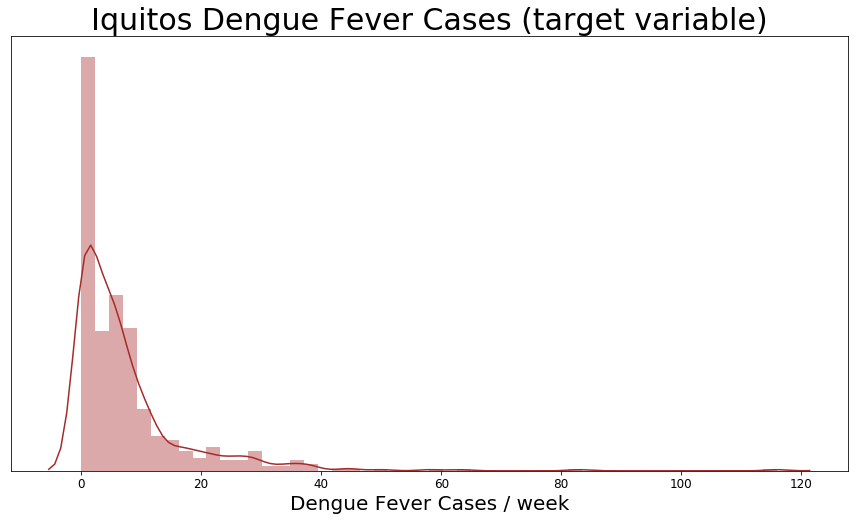

In [3]:
#target variable
plt.figure(figsize=[15,8])
sns.distplot(iq.total_cases, bins=50, color='brown')
plt.yticks([])
plt.xticks(size=12)
plt.title('Iquitos Dengue Fever Cases (target variable)', size=30)
plt.xlabel('Dengue Fever Cases / week', size=20)
plt.show()

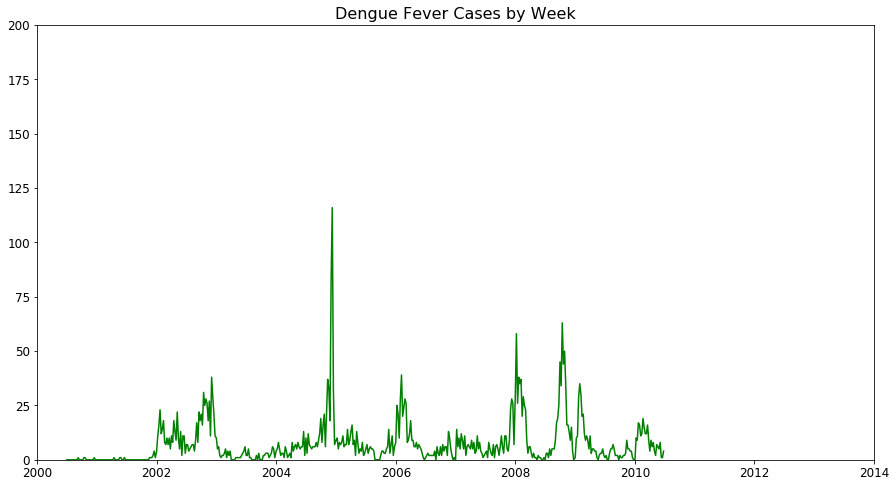

In [4]:
plt.figure(figsize=[15,8])
plt.title('Dengue Fever Cases by Week', size=16)
plt.plot(pd.to_datetime(iq.week_start_date), iq.total_cases, color='green')
plt.xlim(['2000-01-01','2013-12-31' ])
plt.ylim([0,200])
plt.xticks(size=12)
plt.yticks(size=12)
plt.show()

## Date Issue & Correction
Some weeks have a mistaken weeknumber value, since the max for some years (ex 2005) is 53 despite still only having 52 unique weeks:

In [5]:
for year in iq.year.unique():
    print(f'{year} max: {max(iq[iq.year==year]["weekofyear"])}\
      | min: {min(iq[iq.year==year]["weekofyear"])}\
      | uniques: {iq[iq.year==year]["weekofyear"].nunique()}')

2000 max: 51      | min: 26      | uniques: 26
2001 max: 52      | min: 1      | uniques: 52
2002 max: 52      | min: 1      | uniques: 52
2003 max: 52      | min: 1      | uniques: 52
2004 max: 52      | min: 1      | uniques: 52
2005 max: 53      | min: 1      | uniques: 52
2006 max: 52      | min: 1      | uniques: 52
2007 max: 52      | min: 1      | uniques: 52
2008 max: 52      | min: 1      | uniques: 52
2009 max: 52      | min: 1      | uniques: 52
2010 max: 53      | min: 1      | uniques: 26


A closer look shows that it's the **first** week of the year that is registering as week 53:

In [6]:
for year in [2005,2006,2010]:
    display(iq[iq.year==year][['city','year','weekofyear','week_start_date']].head(3))

,city,year,weekofyear,week_start_date
1170,iq,2005,53,2005-01-01
1171,iq,2005,1,2005-01-08
1172,iq,2005,2,2005-01-15


,city,year,weekofyear,week_start_date
1222,iq,2006,52,2006-01-01
1223,iq,2006,1,2006-01-08
1224,iq,2006,2,2006-01-15


,city,year,weekofyear,week_start_date
1430,iq,2010,53,2010-01-01
1431,iq,2010,1,2010-01-08
1432,iq,2010,2,2010-01-15


This can be corrected by two steps:
- incrementing all the week values by one. This would make the first week 54, and the rest of the weeks should be correct
- reduce any week values over 52 (i.e. the first week only) to 1.

In [7]:
#Increment all week values by one for all problem years
iq.loc[:,'weekofyear_fixed'] = np.where(iq.year==2005,iq.weekofyear+1, iq.weekofyear)
iq.loc[:,'weekofyear_fixed'] = np.where(iq.year==2006,iq.weekofyear_fixed+1, iq.weekofyear_fixed)
iq.loc[:,'weekofyear_fixed'] = np.where(iq.year==2010,iq.weekofyear_fixed+1, iq.weekofyear_fixed)

#Reduce any week values over 52 down to 1    
iq.loc[:,'weekofyear_fixed'] = np.where(iq.weekofyear_fixed>52,1, iq.weekofyear_fixed)

#Check Solution
for year in iq.year.unique():
    print(f'{year} max: {max(iq[iq.year==year]["weekofyear_fixed"])}\
  | min: {min(iq[iq.year==year]["weekofyear_fixed"])}\
  | uniques: {iq[iq.year==year]["weekofyear_fixed"].nunique()}')
#Much better!

2000 max: 51  | min: 26  | uniques: 26
2001 max: 52  | min: 1  | uniques: 52
2002 max: 52  | min: 1  | uniques: 52
2003 max: 52  | min: 1  | uniques: 52
2004 max: 52  | min: 1  | uniques: 52
2005 max: 52  | min: 1  | uniques: 52
2006 max: 52  | min: 1  | uniques: 52
2007 max: 52  | min: 1  | uniques: 52
2008 max: 52  | min: 1  | uniques: 52
2009 max: 52  | min: 1  | uniques: 52
2010 max: 26  | min: 1  | uniques: 26


### Correcting the Test Data as well

In [8]:
testdata = pd.read_csv('data/dengue_features_test.csv')
iqtest = testdata[testdata.city=='iq'].copy()

In [9]:
#Increment all week values by one for all problem years
iqtest.loc[:,'weekofyear_fixed'] = np.where(iqtest.year==2012,iqtest.weekofyear+1, iqtest.weekofyear)
iqtest.loc[:,'weekofyear_fixed'] = np.where(iqtest.year==2011,iqtest.weekofyear_fixed+1, iqtest.weekofyear_fixed)

#Reduce any week values over 52 down to 1    
iqtest.loc[:,'weekofyear_fixed'] = np.where(iqtest.weekofyear_fixed>52,1, iqtest.weekofyear_fixed)


In [10]:
for year in iqtest.year.unique():
    print(f'{year} max: {max(iqtest[iqtest.year==year]["weekofyear_fixed"])}\
  | min: {min(iqtest[iqtest.year==year]["weekofyear_fixed"])}\
  | uniques: {iqtest[iqtest.year==year]["weekofyear_fixed"].nunique()}')

2010 max: 51  | min: 26  | uniques: 26
2011 max: 52  | min: 1  | uniques: 52
2012 max: 52  | min: 1  | uniques: 52
2013 max: 26  | min: 1  | uniques: 26


## Nan values
Iquitos has Nan values, which will have to be imputed:

In [11]:
iq.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 520 entries, 936 to 1455
Data columns (total 26 columns):
city                                     520 non-null object
year                                     520 non-null int64
weekofyear                               520 non-null int64
week_start_date                          520 non-null object
ndvi_ne                                  517 non-null float64
ndvi_nw                                  517 non-null float64
ndvi_se                                  517 non-null float64
ndvi_sw                                  517 non-null float64
precipitation_amt_mm                     516 non-null float64
reanalysis_air_temp_k                    516 non-null float64
reanalysis_avg_temp_k                    516 non-null float64
reanalysis_dew_point_temp_k              516 non-null float64
reanalysis_max_air_temp_k                516 non-null float64
reanalysis_min_air_temp_k                516 non-null float64
reanalysis_precip_amt_kg_per_m

Since this is time series data, with even evenly spaced observations, we can use interpolation to estimate the missing values. I'll use a linear method here:

In [12]:
#Fill nas with interpolation
iq = iq.interpolate(method='linear')

# Feature Engineering 

In [13]:
#New Dataframe to hold the features that are chosen or engineered
feats = iq[['city', 'year', 'weekofyear_fixed', 'total_cases']].copy()

## Seasonality

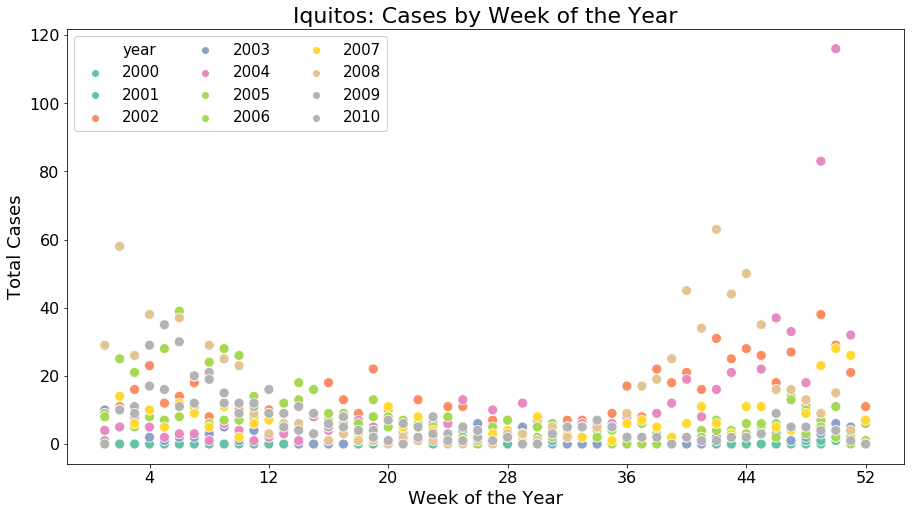

In [14]:
plt.figure(figsize=[15,8])
plt.title('Iquitos: Cases by Week of the Year', size=22)
sns.scatterplot(x='weekofyear_fixed',y='total_cases', hue='year', s=100,
                data=iq, palette='Set2',legend='full')
plt.legend(loc=2, framealpha=1, ncol=3, prop={'size': 15})
plt.ylabel('Total Cases',size=18)
plt.xlabel('Week of the Year',size=18)
plt.xticks([4,12,20,28,36,44,52], size=16)
plt.yticks(size=16)
plt.show()

There's enough seasonality here to consider making features out of the seasons. 

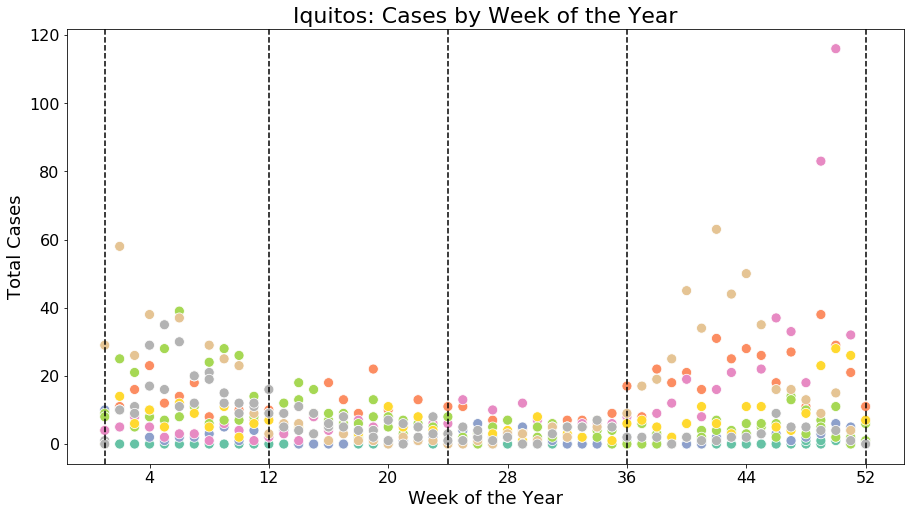

In [15]:
plt.figure(figsize=[15,8])
plt.title('Iquitos: Cases by Week of the Year', size=22)
sns.scatterplot(x='weekofyear_fixed',y='total_cases', hue='year', s=100,
                data=iq, palette='Set2',legend=None)

plot_windows = [1,12,24,36,52]
for w in plot_windows:
    plt.axvline(w, linestyle='--',color='black')
plt.ylabel('Total Cases',size=18)
plt.xlabel('Week of the Year',size=18)
plt.xticks([4,12,20,28,36,44,52], size=16)
plt.yticks(size=16)
plt.show()

In [16]:
# Create categorical variable for each of the 3 seasons 
cutoffs = [12, 24, 36]
feats['fall'] = np.where((feats.weekofyear_fixed<cutoffs[0]), 1, 0)

feats['winter'] = np.where((feats.weekofyear_fixed>=cutoffs[0]) &
                           (feats.weekofyear_fixed<cutoffs[1]), 1, 0)
feats['spring'] = np.where((feats.weekofyear_fixed>=cutoffs[1]) &
                           (feats.weekofyear_fixed<cutoffs[2]), 1, 0)
feats['summer'] = np.where((feats.weekofyear_fixed>=cutoffs[2]), 1, 0)

### Temperature

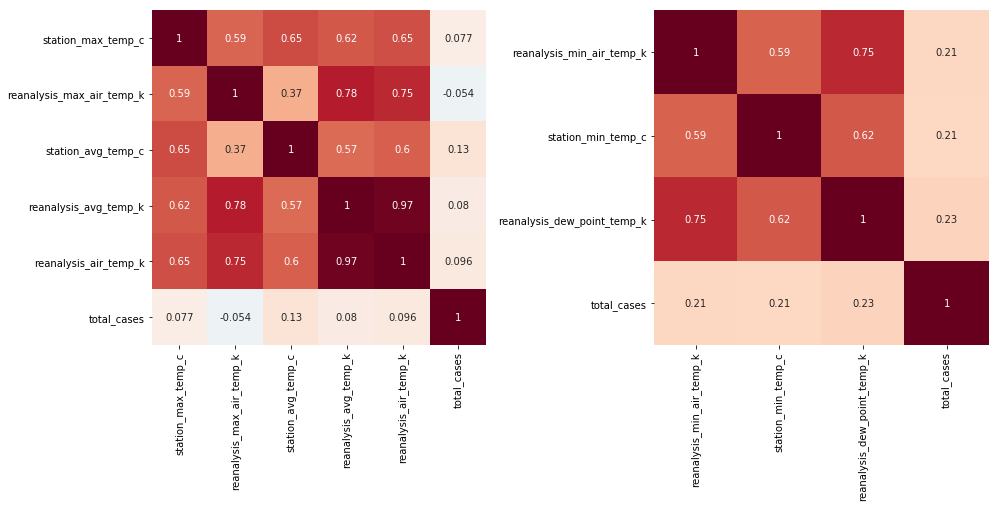

In [17]:
tempshigh = iq[['station_max_temp_c',
            'reanalysis_max_air_temp_k',
            'station_avg_temp_c',
            'reanalysis_avg_temp_k',
            'reanalysis_air_temp_k',
           'total_cases', ]].copy()

tempslow = iq[[ 'reanalysis_min_air_temp_k',
     'station_min_temp_c',
     'reanalysis_dew_point_temp_k',
     'total_cases']].copy()
plt.figure(figsize=[15,15])
plt.subplot(1,2,1)
sns.heatmap(tempshigh.corr(),square=True, vmin=-1, vmax=1, 
                center=0, cbar=False, cmap='RdBu_r', annot=True)
plt.subplot(1,2,2)
sns.heatmap(tempslow.corr(),square=True, vmin=-1, vmax=1, 
                center=0, cbar=False, cmap='RdBu_r', annot=True)
plt.subplots_adjust(wspace=.5)
plt.show()

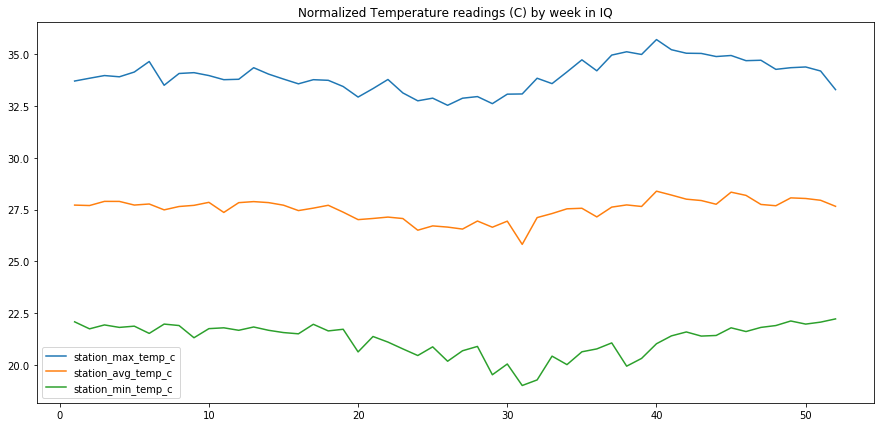

In [18]:
plt.figure(figsize=[15,7])
plt.title('Normalized Temperature readings (C) by week in IQ')
for i in ['station_max_temp_c','station_avg_temp_c','station_min_temp_c']:
    plt.plot(iq.groupby('weekofyear_fixed')[i].mean(),label=i)
plt.legend()
plt.show()

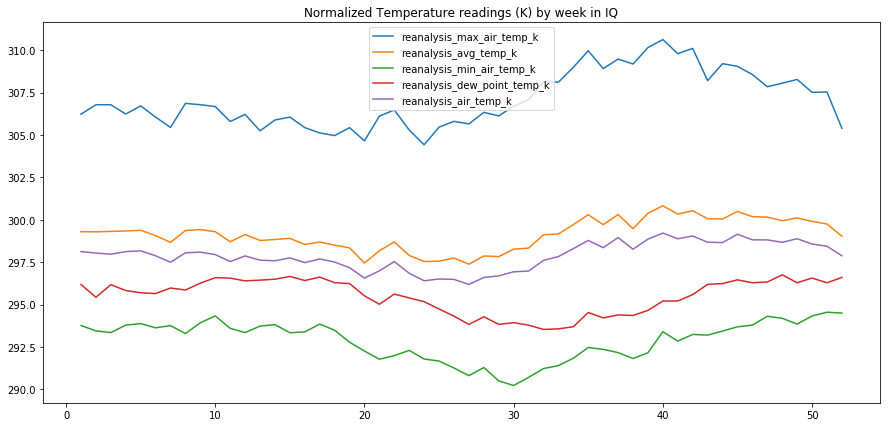

In [19]:
plt.figure(figsize=[15,7])
plt.title('Normalized Temperature readings (K) by week in IQ')
for i in ['reanalysis_max_air_temp_k',
            'reanalysis_avg_temp_k',
            'reanalysis_min_air_temp_k',
            'reanalysis_dew_point_temp_k',
            'reanalysis_air_temp_k',]:
    plt.plot(iq.groupby('weekofyear_fixed')[i].mean(),label=i)
plt.legend()
plt.show()

####  Conclusion: Temperature:

I will keep those with higher than .1 correlations with total cases:

In [20]:
for v in ['station_avg_temp_c','reanalysis_min_air_temp_k', 
          'station_min_temp_c','reanalysis_dew_point_temp_k']:
    feats[v] = iq[v].copy()

### Other temperature measurements and humidity

In [21]:
othertemps = ['total_cases','station_diur_temp_rng_c', 'reanalysis_tdtr_k','reanalysis_relative_humidity_percent',
       'reanalysis_specific_humidity_g_per_kg']
iq[othertemps].corr()

,total_cases,station_diur_temp_rng_c,reanalysis_tdtr_k,reanalysis_relative_humidity_percent,reanalysis_specific_humidity_g_per_kg
total_cases,1.000000,-0.036134,-0.132191,0.129486,0.235218
station_diur_temp_rng_c,-0.036134,1.000000,0.557090,-0.550234,-0.231201
reanalysis_tdtr_k,-0.132191,0.557090,1.000000,-0.895984,-0.593731
reanalysis_relative_humidity_percent,0.129486,-0.550234,-0.895984,1.000000,0.722881
reanalysis_specific_humidity_g_per_kg,0.235218,-0.231201,-0.593731,0.722881,1.000000


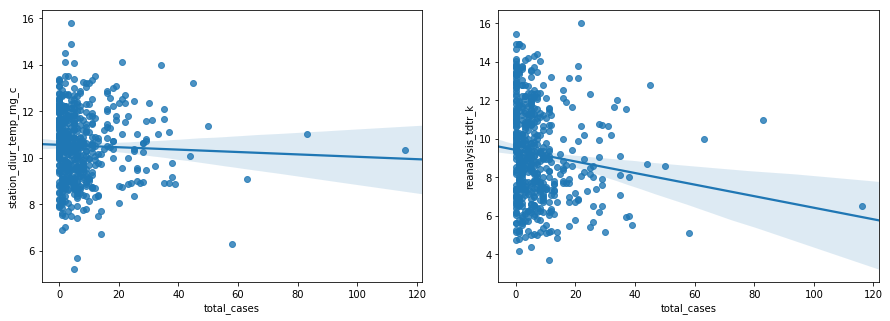

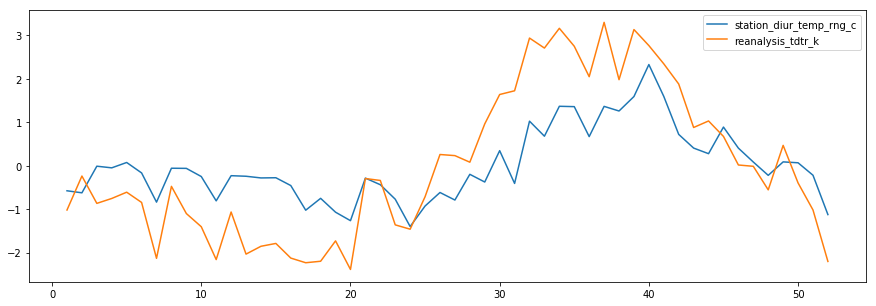

In [22]:
v = 'station_diur_temp_rng_c'
v2 = 'reanalysis_tdtr_k'

plt.figure(figsize=[15,5])
plt.subplot(121)
sns.regplot(iq.total_cases, iq[v])
plt.subplot(122)
sns.regplot(iq.total_cases, iq[v2])
plt.show()
plt.figure(figsize=[15,5])

plt.plot(iq.groupby('weekofyear_fixed')[v].mean() - 
                 iq[v].mean(),
            label=v)

plt.plot(iq.groupby('weekofyear_fixed')[v2].mean() - 
                 iq[v2].mean(),
            label=v2)
plt.legend()
plt.show()

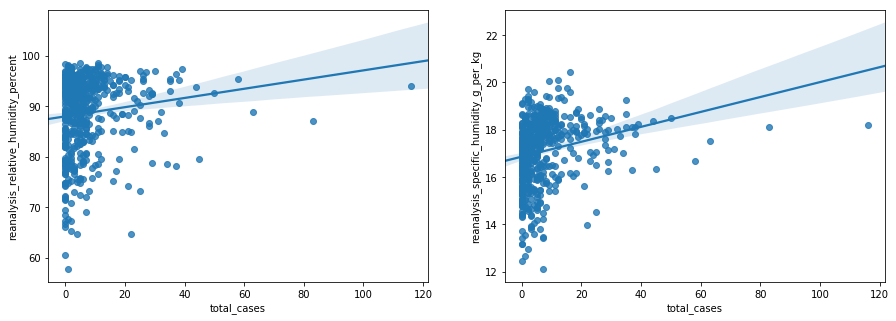

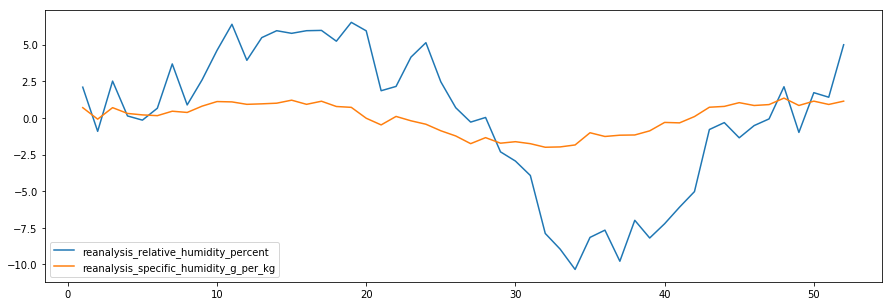

In [23]:
v = 'reanalysis_relative_humidity_percent'
v2 = 'reanalysis_specific_humidity_g_per_kg'
plt.figure(figsize=[15,5])
plt.subplot(121)
sns.regplot(iq.total_cases, iq[v])
plt.subplot(122)
sns.regplot(iq.total_cases, iq[v2])
plt.show()
plt.figure(figsize=[15,5])

plt.plot(iq.groupby('weekofyear_fixed')[v].mean() - 
                 iq[v].mean(),
            label=v)

plt.plot(iq.groupby('weekofyear_fixed')[v2].mean() - 
                 iq[v2].mean(),
            label=v2)
plt.legend()
plt.show()

#### Conclusion: Humidity and temperature range

I will include the higher correlation in each category

In [24]:
feats.loc[:,'reanalysis_tdtr_k'] = iq['reanalysis_tdtr_k']
feats.loc[:,'reanalysis_specific_humidity_g_per_kg'] = iq['reanalysis_specific_humidity_g_per_kg']

### Rain

In [25]:
rain = ['total_cases',
       'precipitation_amt_mm', 
       'reanalysis_precip_amt_kg_per_m2',
       #'reanalysis_sat_precip_amt_mm', # identical to precipitation_amt_mm
       'station_precip_mm']
iq[rain].corr()

,total_cases,precipitation_amt_mm,reanalysis_precip_amt_kg_per_m2,station_precip_mm
total_cases,1.000000,0.090628,0.101150,0.044568
precipitation_amt_mm,0.090628,1.000000,0.339115,0.374506
reanalysis_precip_amt_kg_per_m2,0.101150,0.339115,1.000000,0.154838
station_precip_mm,0.044568,0.374506,0.154838,1.000000


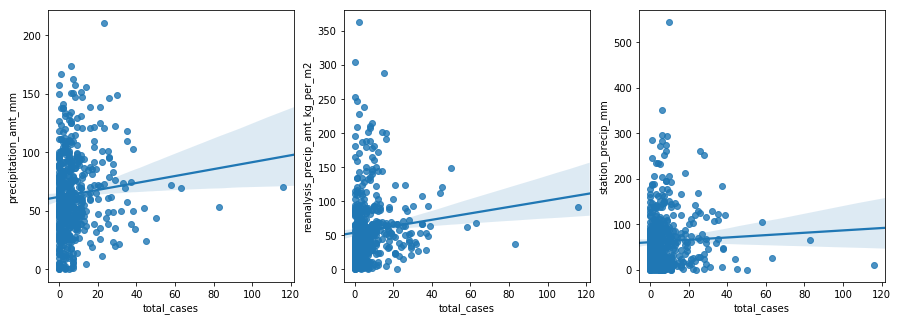

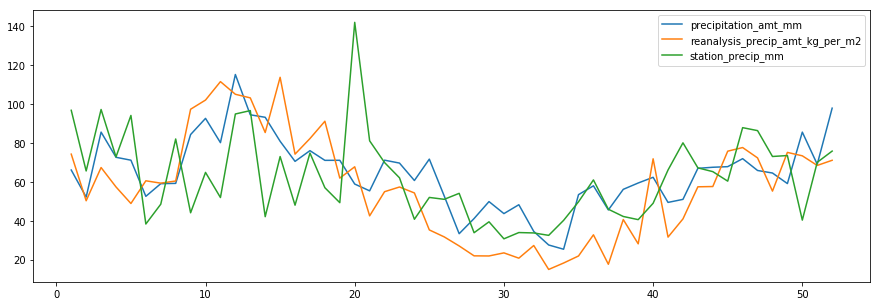

In [26]:
v = 'precipitation_amt_mm'
v2 = 'reanalysis_precip_amt_kg_per_m2'
v3 = 'station_precip_mm'

plt.figure(figsize=[15,5])
plt.subplot(131)
sns.regplot(iq.total_cases, iq[v])
plt.subplot(132)
sns.regplot(iq.total_cases, iq[v2])
plt.subplot(133)
sns.regplot(iq.total_cases, iq[v3])
plt.show()
plt.figure(figsize=[15,5])

plt.plot(iq.groupby('weekofyear_fixed')[v].mean(), 
            label=v)
plt.plot(iq.groupby('weekofyear_fixed')[v2].mean(),
            label=v2)
plt.plot(iq.groupby('weekofyear_fixed')[v3].mean(), 
            label=v3)
plt.legend()
plt.show()

#### Conclusion: Rain

I will include only the strongest correlated variable, precipitation_amt_mm

In [27]:
feats.loc[:,'precipitation_amt_mm'] = iq['precipitation_amt_mm']

### Vegetation

In [28]:
vegs = ['total_cases', 'ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw']
iq[vegs].corr()

,total_cases,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw
total_cases,1.000000,0.020794,-0.009952,-0.040643,0.032812
ndvi_ne,0.020794,1.000000,0.764200,0.769360,0.842922
ndvi_nw,-0.009952,0.764200,1.000000,0.644541,0.765389
ndvi_se,-0.040643,0.769360,0.644541,1.000000,0.715192
ndvi_sw,0.032812,0.842922,0.765389,0.715192,1.000000


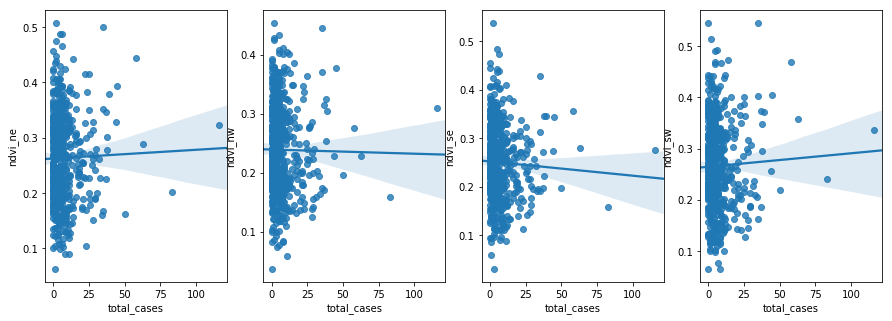

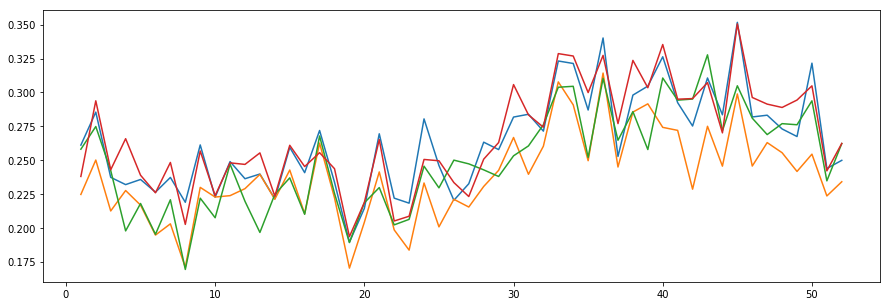

In [29]:
plt.figure(figsize=[15,5])
for i,col in enumerate(vegs[1:]):
    plt.subplot(1,4,i+1)
    sns.regplot(iq.total_cases, iq[col])
plt.show()

plt.figure(figsize=[15,5])
for v in vegs[1:]:
    plt.plot(iq.groupby('weekofyear_fixed')[v].mean(), 
            label=v)
plt.show()

#### Conclusion: Vegetation
Excluded

In [30]:
feats.head()

,city,year,weekofyear_fixed,total_cases,fall,winter,spring,summer,station_avg_temp_c,reanalysis_min_air_temp_k,station_min_temp_c,reanalysis_dew_point_temp_k,reanalysis_tdtr_k,reanalysis_specific_humidity_g_per_kg,precipitation_amt_mm
936,iq,2000,26,0,0,0,1,0,26.400000,293.1,20.7,295.184286,8.928571,16.651429,25.41
937,iq,2000,27,0,0,0,1,0,26.900000,291.1,20.8,295.358571,10.314286,16.862857,60.61
938,iq,2000,28,0,0,0,1,0,26.800000,292.6,20.7,295.622857,7.385714,17.120000,55.52
939,iq,2000,29,0,0,0,1,0,25.766667,288.6,14.7,292.797143,9.114286,14.431429,5.60
940,iq,2000,30,0,0,0,1,0,26.600000,291.5,19.1,293.957143,9.500000,15.444286,62.76


# "Vanilla" Supervised Modelling Exploration:
Could supervised techniques find a pattern in this data? with chosen features? The point of this exploration is to see which models might be useable for Lagged Features technique.

In [31]:
def examine(y_pred, y_test):
    c = pd.DataFrame({
        'y' : y_test,
        'p' : y_pred
     })
    c = c.sort_index() # check this?
    plt.figure(figsize=[15,4])
    plt.plot(c.y, color='green')
    plt.plot(c.p, color='red')
    plt.show()

In [32]:
X = feats.drop(['total_cases', 'city', 'year', 'weekofyear_fixed'], axis=1)
y = feats.total_cases

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=False)
print(X_train.shape)
print(X_test.shape)

(364, 11)
(156, 11)


#### Linear Regression

In [33]:
regr = LinearRegression()
regr.fit(X_train,y_train)
y_pred = regr.predict(X_test)
print(cross_val_score(regr,X_test,y_test,scoring='neg_mean_absolute_error', cv=3))
print(mean_absolute_error(y_test,y_pred,multioutput='uniform_average'))

[-8.61336352 -9.7690248  -8.73201094]
7.165355679932558


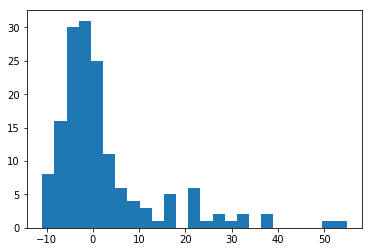

In [34]:
residual = y_test - y_pred
plt.hist(residual, bins=25)
plt.show()

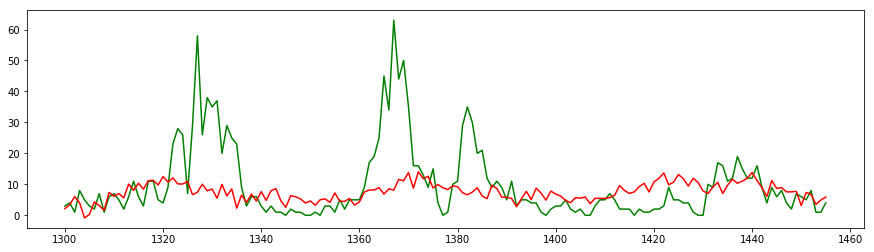

In [35]:
examine(y_pred, y_test)

### Random Forest Regressor

In [36]:
rfr = RandomForestRegressor(max_depth=50, n_estimators=200, criterion='mae')
rfr.fit(X_train,y_train)
y_pred = rfr.predict(X_test)
print(mean_absolute_error(y_test,y_pred,multioutput='uniform_average'))
print(cross_val_score(rfr,X_test,y_test,scoring='neg_mean_absolute_error', cv=3))

8.191810897435898
[-9.04644231 -9.93057692 -8.20894231]


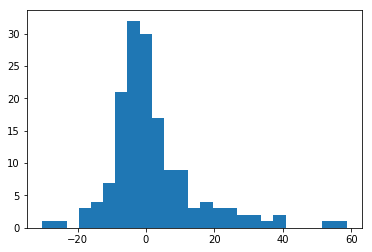

In [37]:
residual = y_test - y_pred
plt.hist(residual, bins=25)
plt.show()

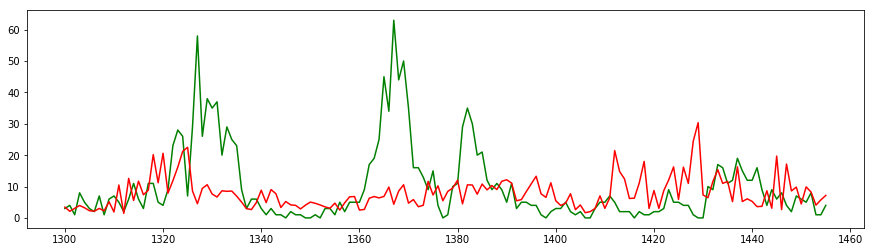

In [38]:
examine(y_pred, y_test)

### KNN Regressor

In [39]:
knn = KNeighborsRegressor(n_neighbors=10, weights='distance')
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
print(mean_absolute_error(y_test,y_pred,multioutput='uniform_average'))
print(cross_val_score(knn,X_test,y_test,scoring='neg_mean_absolute_error', cv=3))

7.709774325552632
[ -9.14269572 -10.4003353   -7.30976455]


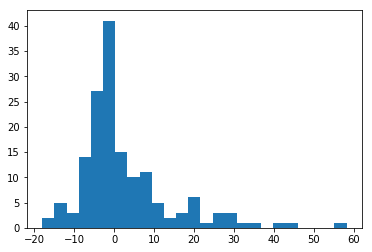

In [40]:
residual = y_test - y_pred
plt.hist(residual, bins=25)
plt.show()

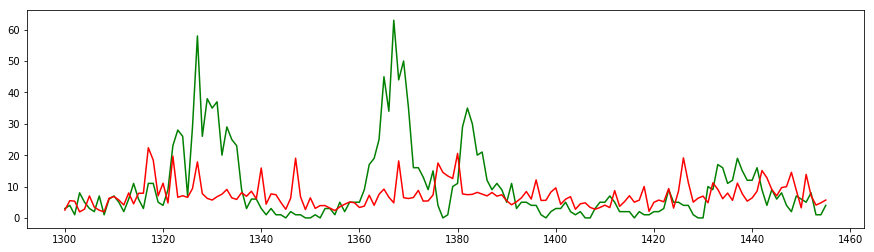

In [41]:
examine(y_pred, y_test)

###  Gradient Boosting Regressor

In [42]:
gbr = GradientBoostingRegressor(criterion='mae',max_depth=2,
                                learning_rate=.01, n_estimators=100)
gbr.fit(X_train,y_train)
y_pred = gbr.predict(X_test)
print(mean_absolute_error(y_test,y_pred,multioutput='uniform_average'))
print(cross_val_score(gbr,X_test,y_test,scoring='neg_mean_absolute_error', cv=3))

7.496959738464436
[-7.27446087 -9.47723724 -6.68591719]


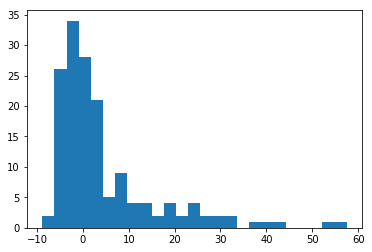

In [43]:
residual = y_test - y_pred
plt.hist(residual, bins=25)
plt.show()

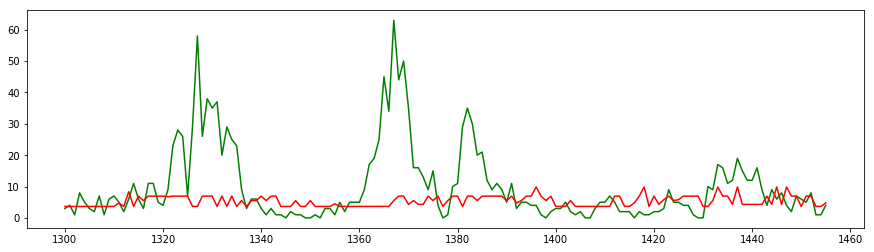

In [44]:
examine(y_pred, y_test)

###  Support Vector Regression

In [45]:
svr = SVR(gamma='auto')
svr.fit(X_train,y_train)
y_pred = svr.predict(X_test)
print(mean_absolute_error(y_test,y_pred,multioutput='uniform_average'))
print(cross_val_score(svr,X_test,y_test,scoring='neg_mean_absolute_error', cv=3))

7.542321903642014
[ -8.43663976 -10.29229069  -4.1395873 ]


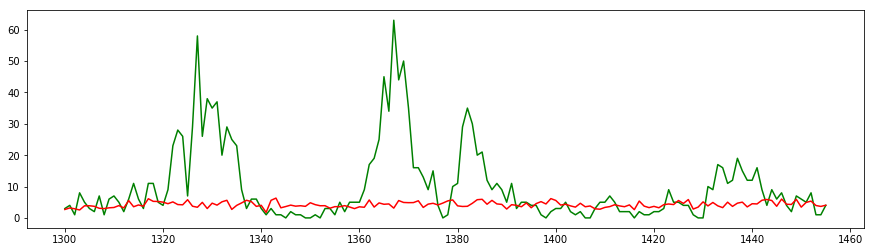

In [46]:
examine(y_pred, y_test)

### Negative Binomial Regression

In [47]:
smX_train = X_train.copy()
smX_train.loc[:,'total_cases'] = y_train
smX_test = X_test.copy()
smX_test.loc[:,'total_cases'] = y_test

In [48]:
#create statsmodels formula
formula = 'total_cases ~ '
for i in X.columns:
    formula = formula + str(i) + ' + '
formula =  formula[:-3] #trim the last plus sign
formula

'total_cases ~ fall + winter + spring + summer + station_avg_temp_c + reanalysis_min_air_temp_k + station_min_temp_c + reanalysis_dew_point_temp_k + reanalysis_tdtr_k + reanalysis_specific_humidity_g_per_kg + precipitation_amt_mm'

In [49]:
model = smf.glm(formula=formula, data=smX_train, 
               family=sm.families.NegativeBinomial(alpha=1e-6))

In [50]:
results = model.fit()
predictions = results.predict(smX_test).astype(int)
score = eval_measures.meanabs(predictions, smX_test.total_cases)
score

7.051282051282051

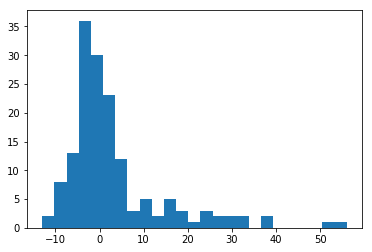

In [51]:
residual = y_test - predictions
plt.hist(residual, bins=25)
plt.show()

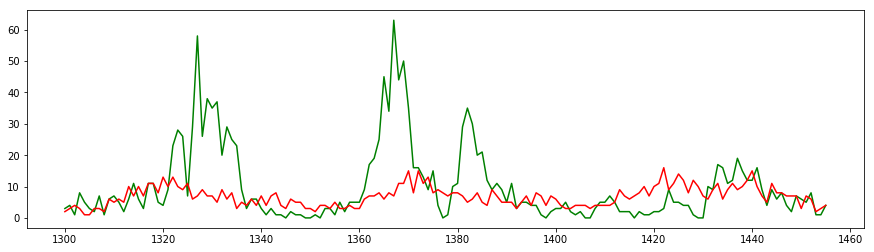

In [52]:
examine(predictions, y_test)

## Lagged Features: Supervised Learning Models with Time Series Data

In [53]:
iqshiftedfeats = feats[['city', 'year', 'weekofyear_fixed', 'total_cases',
                      'winter', 'spring', 'summer', 'fall']].copy()
for i in ['station_avg_temp_c',
       'reanalysis_min_air_temp_k', 'station_min_temp_c',
       'reanalysis_dew_point_temp_k', 'reanalysis_tdtr_k', 
       'reanalysis_specific_humidity_g_per_kg',
       'precipitation_amt_mm']:
    
    #Each sample gets 3 weeks of history as features
    iqshiftedfeats[i] = feats[i]
    iqshiftedfeats[i+'_1lag'] = feats[i].shift(-1)
    iqshiftedfeats[i+'_2lag'] = feats[i].shift(-2)
    iqshiftedfeats[i+'_3lag'] = feats[i].shift(-3)

iqshiftedfeats = iqshiftedfeats.fillna(method='ffill')
iqshiftedfeats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 520 entries, 936 to 1455
Data columns (total 36 columns):
city                                          520 non-null object
year                                          520 non-null int64
weekofyear_fixed                              520 non-null int64
total_cases                                   520 non-null int64
winter                                        520 non-null int32
spring                                        520 non-null int32
summer                                        520 non-null int32
fall                                          520 non-null int32
station_avg_temp_c                            520 non-null float64
station_avg_temp_c_1lag                       520 non-null float64
station_avg_temp_c_2lag                       520 non-null float64
station_avg_temp_c_3lag                       520 non-null float64
reanalysis_min_air_temp_k                     520 non-null float64
reanalysis_min_air_temp_k_1lag      

In [54]:
X = iqshiftedfeats.drop(['total_cases', 'city', 'year', 'weekofyear_fixed'], axis=1)
y = iqshiftedfeats.total_cases

In [55]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=False)
print(X_train.shape)
print(X_test.shape)

(364, 32)
(156, 32)


#### Linear Regression

In [56]:
regr = LinearRegression()
regr.fit(X_train,y_train)
y_pred = regr.predict(X_test)
print(cross_val_score(regr,X_test,y_test,scoring='neg_mean_absolute_error', cv=3))
print(mean_absolute_error(y_test,y_pred,multioutput='uniform_average'))

[-10.93368603 -10.52170974 -16.47427636]
7.669179159333826


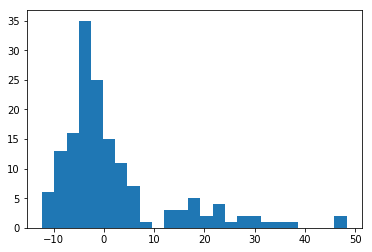

In [57]:
residual = y_test - y_pred
plt.hist(residual, bins=25)
plt.show()

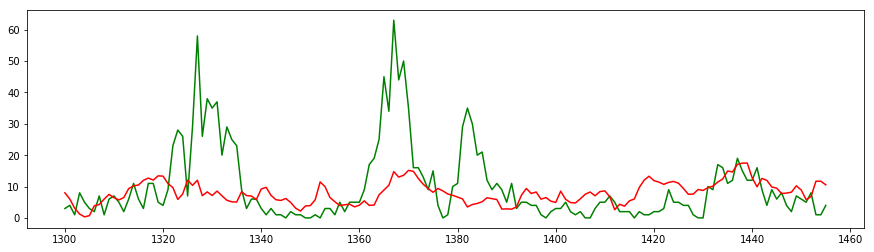

In [58]:
examine(y_pred, y_test)

### Random Forest Regressor

In [59]:
rfr = RandomForestRegressor(max_depth=50, n_estimators=200, criterion='mse')
rfr.fit(X_train,y_train)
y_pred = rfr.predict(X_test)
print(mean_absolute_error(y_test,y_pred,multioutput='uniform_average'))
print(cross_val_score(rfr,X_test,y_test,scoring='neg_mean_absolute_error', cv=3))

7.6153525641025634
[ -7.75413462  -9.94576923 -12.46586538]


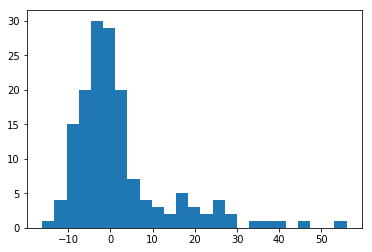

In [60]:
residual = y_test - y_pred
plt.hist(residual, bins=25)
plt.show()

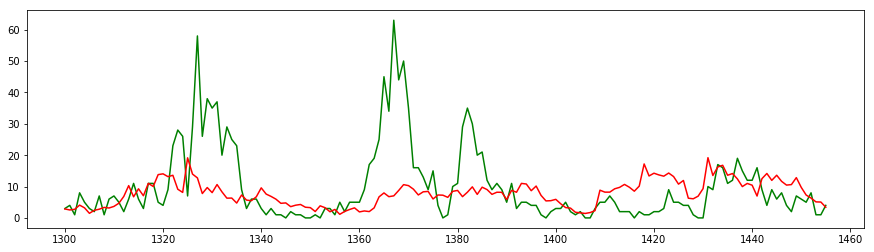

In [61]:
examine(y_pred, y_test)

In [62]:
[(X_train.columns[i], rfr.feature_importances_[i]) for i in range(len(X_train.columns))]

[('winter', 0.001598228653270492),
 ('spring', 0.0001732547710729564),
 ('summer', 0.012379120058268358),
 ('fall', 0.0034135043235364697),
 ('station_avg_temp_c', 0.024584379625349234),
 ('station_avg_temp_c_1lag', 0.03037535951998478),
 ('station_avg_temp_c_2lag', 0.020805996089272864),
 ('station_avg_temp_c_3lag', 0.016318063984224324),
 ('reanalysis_min_air_temp_k', 0.023247727938816312),
 ('reanalysis_min_air_temp_k_1lag', 0.015187611102807731),
 ('reanalysis_min_air_temp_k_2lag', 0.028287939337250087),
 ('reanalysis_min_air_temp_k_3lag', 0.029926012240188028),
 ('station_min_temp_c', 0.022504349423333934),
 ('station_min_temp_c_1lag', 0.0313263317001846),
 ('station_min_temp_c_2lag', 0.08328900867768249),
 ('station_min_temp_c_3lag', 0.041555758562930666),
 ('reanalysis_dew_point_temp_k', 0.023220693710856995),
 ('reanalysis_dew_point_temp_k_1lag', 0.017870613433259543),
 ('reanalysis_dew_point_temp_k_2lag', 0.033331370555634295),
 ('reanalysis_dew_point_temp_k_3lag', 0.050546653

### KNN Regressor

In [63]:
knn = KNeighborsRegressor(n_neighbors=10, weights='distance')
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
print(mean_absolute_error(y_test,y_pred,multioutput='uniform_average'))
print(cross_val_score(knn,X_test,y_test,scoring='neg_mean_absolute_error', cv=3))

7.556916192696152
[ -9.97294485 -10.00717476  -7.62928771]


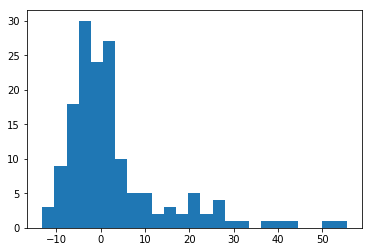

In [64]:
residual = y_test - y_pred
plt.hist(residual, bins=25)
plt.show()

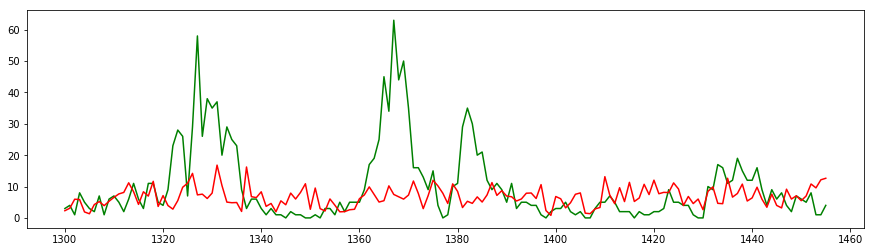

In [65]:
examine(y_pred, y_test)

###  Gradient Boosting Regressor

In [66]:
gbr = GradientBoostingRegressor(criterion='mae',max_depth=4,
                                learning_rate=.01, n_estimators=100)
gbr.fit(X_train,y_train)
y_pred = gbr.predict(X_test)
print(mean_absolute_error(y_test,y_pred,multioutput='uniform_average'))
print(cross_val_score(gbr,X_test,y_test,scoring='neg_mean_absolute_error', cv=3))

7.374255065627494
[ -7.49489671  -9.50381448 -10.40876337]


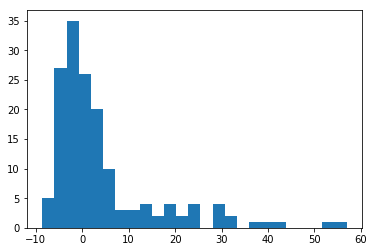

In [67]:
residual = y_test - y_pred
plt.hist(residual, bins=25)
plt.show()

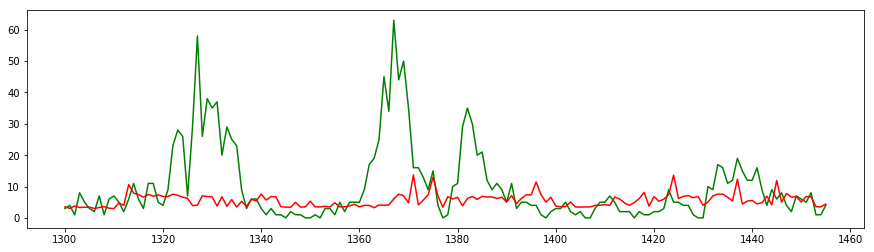

In [68]:
examine(y_pred, y_test)

###  Support Vector Regression

In [69]:
svr = SVR(gamma='scale', kernel='linear')
svr.fit(X_train,y_train)
y_pred = svr.predict(X_test)
print(mean_absolute_error(y_test,y_pred,multioutput='uniform_average'))
print(cross_val_score(svr,X_test,y_test,scoring='neg_mean_absolute_error', cv=3))

7.508965361871082
[ -7.72599141 -10.42746194  -6.52384026]


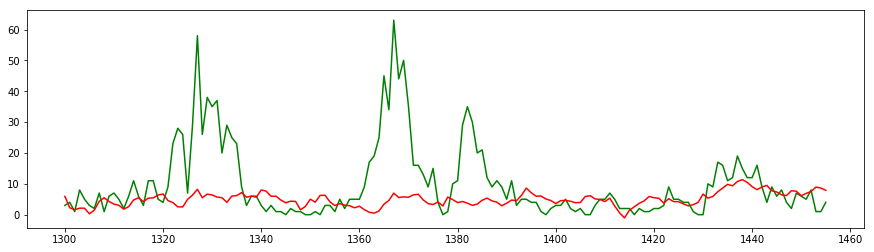

In [70]:
examine(y_pred, y_test)

### Negative Binomial Regression

In [71]:
smX_train = X_train.copy()
smX_train.loc[:,'total_cases'] = y_train
smX_test = X_test.copy()
smX_test.loc[:,'total_cases'] = y_test

In [72]:
#create statsmodels formula
formula = 'total_cases ~ '
for i in X.columns:
    formula = formula + str(i) + ' + '
formula =  formula[:-3] #trim the last plus sign
formula

'total_cases ~ winter + spring + summer + fall + station_avg_temp_c + station_avg_temp_c_1lag + station_avg_temp_c_2lag + station_avg_temp_c_3lag + reanalysis_min_air_temp_k + reanalysis_min_air_temp_k_1lag + reanalysis_min_air_temp_k_2lag + reanalysis_min_air_temp_k_3lag + station_min_temp_c + station_min_temp_c_1lag + station_min_temp_c_2lag + station_min_temp_c_3lag + reanalysis_dew_point_temp_k + reanalysis_dew_point_temp_k_1lag + reanalysis_dew_point_temp_k_2lag + reanalysis_dew_point_temp_k_3lag + reanalysis_tdtr_k + reanalysis_tdtr_k_1lag + reanalysis_tdtr_k_2lag + reanalysis_tdtr_k_3lag + reanalysis_specific_humidity_g_per_kg + reanalysis_specific_humidity_g_per_kg_1lag + reanalysis_specific_humidity_g_per_kg_2lag + reanalysis_specific_humidity_g_per_kg_3lag + precipitation_amt_mm + precipitation_amt_mm_1lag + precipitation_amt_mm_2lag + precipitation_amt_mm_3lag'

In [73]:
model = smf.glm(formula=formula, data=smX_train, 
               family=sm.families.NegativeBinomial(alpha=1e-6))

In [74]:
results = model.fit()
predictions = results.predict(smX_test).astype(int)
score = eval_measures.meanabs(predictions, smX_test.total_cases)
score

7.621794871794871

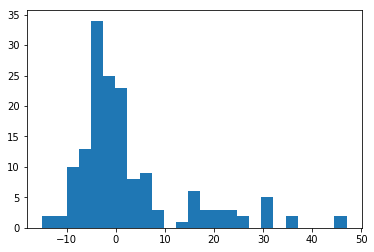

In [75]:
residual = y_test - predictions
plt.hist(residual, bins=25)
plt.show()

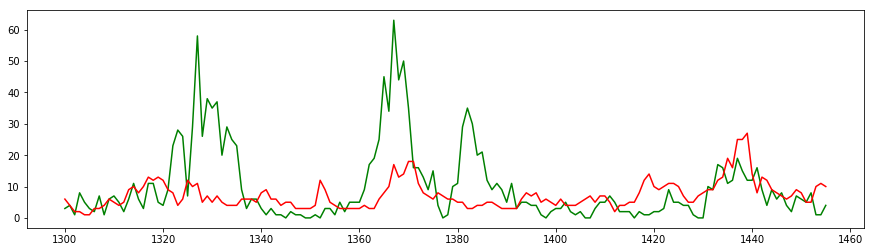

In [76]:
examine(predictions, y_test)